## Remove outliers in the DeltaSigma

## Module Import and configs

In [77]:
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import numpy as np
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import incredible as cr

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
import sys
sys.path.append('/global/u1/z/zzhang13')
from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

## File Imports

In [80]:
chains_dir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/chains/'
datadir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/'
plot_dir = '/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/plots/'

In [81]:
with open(datadir + 'MDPL2_DS_Rvir_SAGE_Ngal_allM_allz.p', 'rb') as handle:
    matched_halo_df = pickle.load(handle)

In [82]:
## Plotting the DeltaSigma
mask = (matched_halo_df.mvir > 5e13) & (matched_halo_df.mvir < 1e14) & (matched_halo_df.scale == 1)
cur_df = matched_halo_df[mask]

## Plotting the Covariance

In [83]:
## Testing the file properties. 
r_bins_log_norm = np.linspace(-1,1,21)
r_bins_lin_norm = 10**r_bins_log_norm
r_cent_log_norm= (r_bins_log_norm[1:] + r_bins_log_norm[:-1])/2
r_cent_lin_norm = 10**r_cent_log_norm

M5e+13-1e+14, z=0.00, 489


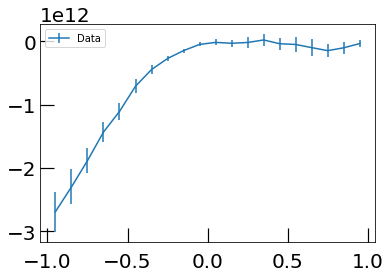

In [84]:
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

nBootstrap = 10
mass_min = 5e13; mass_max = 1e14
cur_a_bin = 1

mask = (matched_halo_df.mvir >= mass_min) & (matched_halo_df.mvir < mass_max) & (matched_halo_df.scale == cur_a_bin) 
cur_df = matched_halo_df[mask]
print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))
            
##Computing the Covariance##
##Compute Cov. and error total
xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['mvir'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                np.log10(np.array(cur_df['Ngal_Rvir'],dtype=float)), nBootstrap=nBootstrap)
cov_ds_ngal_kllr = output['covariance']
cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)
        
##Data vector for chains
x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr
        
plt.errorbar(x_data, y_data, yerr=y_err, label='Data')
plt.legend()
plt.show()

## Outlier removal

In [41]:
## Remove the outer bins that are causing problems. 
delta_sigma = np.array(np.vstack(cur_df.delta_sigma))
ds_group = [delta_sigma[:,i] for i in range(14,20)]

In [60]:
indices = np.where(np.absolute(zscore(ds_group, axis=1)) > 3)[1] ##Using 3-sigma rule 
indices = np.unique(indices)
print(indices)

[243 265 284 302 309 333 335 343 446]


In [67]:
outlier_id = cur_df.iloc[indices]['CtreesHaloID']
print(outlier_id)

849     12593245088
892     12584539440
911     12592677223
954     12593318950
961     12592751765
1017    12593394079
1019    12593393735
1027    12593356929
1182    12593540695
Name: CtreesHaloID, dtype: object


In [72]:
matched_halo_df = matched_halo_df.loc[~matched_halo_df.CtreesHaloID.isin(outlier_id)]

## Re plot after outlier removal

M5e+13-1e+14, z=0.00, 489


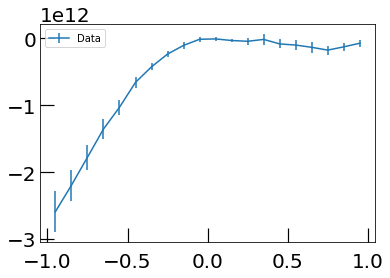

In [75]:
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

nBootstrap = 10
mass_min = 5e13; mass_max = 1e14
cur_a_bin = 1

mask = (matched_halo_df.mvir >= mass_min) & (matched_halo_df.mvir < mass_max) & (matched_halo_df.scale == cur_a_bin) 
cur_df = matched_halo_df[mask]
print('M{:.2g}-{:.2g}, z={:.2f}, {}'.format(mass_min, mass_max, 1/cur_a_bin-1, len(cur_df)))
            
##Computing the Covariance##
##Compute Cov. and error total
xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['mvir'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                np.log10(np.array(cur_df['Ngal_Rvir'],dtype=float)), nBootstrap=nBootstrap)
cov_ds_ngal_kllr = output['covariance']
cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)
        
##Data vector for chains
x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr
        
plt.errorbar(x_data, y_data, yerr=y_err, label='Data')
plt.legend()
plt.show()

## Save the file

In [76]:
with open(datadir + 'MDPL2_DS_Rvir_SAGE_Ngal_allM_allz.p', 'wb') as handle:
    pickle.dump(matched_halo_df, handle)